In [1]:
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabaz_score


In [2]:
# Funtion to read the input
def read_input(input_file):
    points = []    
    labels = []
    with open(input_file, "r") as ins:
        for line in ins:
            tokens = line.split();
            pnt = [float(tokens[0]),float(tokens[1])]
            labels.append(tokens[2])
            points.append(pnt)
    return(points,labels)

In [3]:
# Initialization Funtion
def initialize(point_matrix,k,init):
    
    matrix = np.array(point_matrix)
    N,d = np.shape(matrix)
    total_variance = np.var(matrix)

    var_sampled_factor = random.uniform(0,1)

    initial_var_across_dimesions = []

    # Sample variance across d dimensions
    for i in range(d):
        initial_var_across_dimesions.append(total_variance * var_sampled_factor)

    # Fractioning factor here can be anyting between 2 to 5
    standard_deviation_fraction = (total_variance / (random.randint(2,5) * k)) ** (1/2)

    # K random indices
    random_points = []
    for i in range(k):
        random_points.append(random.randint(0,N-1)) 

    # Initialize the mean of each cluster K 
    # each mean is d dimensional 
    mean_along_each_dimensions = []
    for i in range(k):
        mean_along_each_dimensions.append(np.random.normal(matrix[random_points[i]],standard_deviation_fraction))

    mean_matrix = np.asarray(mean_along_each_dimensions)
    
    # Have d dimensions for all k clusters, the variances
    initial_var_across_dimesions = np.asarray([initial_var_across_dimesions]*k)

    # Initialize the cluster counts
    cluster_counts = calculate_cluster_counts(None,N,k,init)

    # Initialize the probablities for k clusters
    probablities = []
    for i in cluster_counts:
        probablities.append( i / N)

    return mean_matrix,initial_var_across_dimesions,probablities,cluster_counts


In [4]:
# log p(X,Z|Theta) : log of joint probablities = = log p(X|Theta) + log p(z)
def log_joint(matrix,cluster_means,cluster_variances,cluster_probablities):
    
    X =  np.asarray(matrix)
    SIGMA = np.asarray(cluster_variances)
    MEANS = np.asarray(cluster_means)
    PROBABLITIES = np.asarray(cluster_probablities)
    
    # [N x 1 x D] - [1 x K x D]
    XX_TRANSPOSE = (X[:,None,:] - MEANS[None,:,:]) ** 2 
    
    XX_TRANSPOSE_By_SIGMA = XX_TRANSPOSE / SIGMA[None,:,:]
    
    # log p(X,Z|Theta) = log p(X|Theta) + log p(z)
    
    # log p(X,Theta)
    Log_Likelihood_R = (- np.log(2 * np.pi) - 0.5 * np.log(SIGMA[None,:,:]) - 0.5 * XX_TRANSPOSE_By_SIGMA).sum(axis=2)
    # log p(z)
    Log_Prior_R = np.log(PROBABLITIES[None,:])
    
    return Log_Likelihood_R + Log_Prior_R

In [5]:
# Log Joint is N x K
# max along axis 1 is along k
# soft_assignments = γnk = exp(ωnk − ω∗n)/ summatoin ( exp(ωnl − ω∗n) ).

# Before exponentiation you can now first subtract ω∗n, which is equivalent to dividing both the numerator and 
# denominator by exp ω∗n γnk = exp(ωnk − ω∗n)/ SUMMATION ( exp(ωnl − ω∗n)).
# This prevents overflow because we marginialize/scale the number of each soft assignment by the max of the exponenet. 
# So we scale down numerator and denominator by taking its exponenet. Division exponent of numerator and sum of exponenets 
# of denominator are always between 0 to 1. Also exponent of very small numbers in underflow case goes to 1 to prevent
# underflow

def soft_assignments(log_joint_val):
    # This is ωnk
    W_nk = np.asarray(log_joint_val)
    # This is ω∗n
    W_nk_max = np.max(W_nk,axis=1)
    # exp(ωnk − ω∗n)
    diff = W_nk - W_nk_max[:,None]
    p = np.exp(diff)
    #γnk = exp(ωnk − ω∗n)/ summatoin ( exp(ωnl − ω∗n) ).
    return p / p.sum(axis=1)[:,None]

In [6]:
# Funtion to calculate log likelihood
def log_likelihood(log_joint_val,soft_assignments_val):
    return (soft_assignments_val * (log_joint_val - np.log(soft_assignments_val))).sum() 

In [7]:
# Funtion to calculate the means of the clusters
def calculate_means(matrix, soft_assignments_val, cluster_counts, K): 
    
    N, d = np.shape(matrix)
    
    ## K × 1
    CLUSTER_COUNTS = np.asarray(cluster_counts)
        
    X_nd = np.asarray(matrix)
    Y_nk = np.asarray(soft_assignments_val)
    
    # N × d --> N × 1 × d
    # X[:, None,:]
    #
    # N × K --> N × K × 1
    # g[:, :, None]
    
    # N × K × d
    # X_nd x Y_nk - > 
    
    probablities = X_nd[:, None,:] * Y_nk[:, :, None]
    MEANS = np.sum(probablities, axis = 0)
        
    return MEANS / CLUSTER_COUNTS[:, None]
    

In [8]:
# Calculate the variance
def calculate_variance(matrix, soft_assignments_vals, means, cluster_counts, K): 
    X = np.asarray(matrix)
    MEANS = np.asarray(means)
    Y_nk = np.asarray(soft_assignments_vals)
    
    # K × 1
    CLUSTER_COUNTS = np.asarray(cluster_counts)
    
    # N × d --> N × 1 × d
    #
    # K × d --> 1 × K × d
    #
    # N × K × d
    
    X_M = (X[:, None,:]  - MEANS[None, :, :]) ** 2
    
    SIGMA = (Y_nk[:, :, None] * X_M).sum(0)
        
    return SIGMA / CLUSTER_COUNTS[:, None]
    

In [9]:
# Function to calculate cluster counts
def calculate_cluster_counts(soft_assignments_val, N, K, init=False): 
    if init: 
        return [N/K] * K
    else: 
        cluster_counts = soft_assignments_val.sum(axis = 0)
        return np.array(cluster_counts)

In [10]:
# Check Convergence
def has_converged(old_likehood,new_likelihood,i):
    if i == 100:
            return True
    elif old_likehood is None:
            return False
    elif abs(old_likehood - new_likelihood) < 0.01:
            return True
    elif new_likelihood < old_likehood:
            return True
    else:
            return False
    

In [11]:
def GMM_helper(point_matrix,k,means_i=None,variance_i=None):
     
    # Initialize K clusters with Initialize the mean for each of your clusters by sampling from a Gaussian 
    # distribution centered on a random point in your data. Initialize the variance along each dimension to
    # a random fraction of the total variance in the data. 
    mean_along_each_dimensions,initial_var_across_dimesions,probablities,cluster_counts \
                            = initialize(point_matrix,k,True)
    
    if means_i is not None and variance_i is not None:
        mean_along_each_dimensions = means_i
        initial_var_across_dimesions = variance_i
    
    log_joint_val = log_joint(point_matrix,mean_along_each_dimensions,initial_var_across_dimesions,probablities)
    
    soft_assignments_val = soft_assignments(log_joint_val)
    
    log_likihood_val = log_likelihood(log_joint_val,soft_assignments_val)
    
    prev_log_likihood_val = None
    i = 0
    # E-Step and the M-Step
    while not has_converged(prev_log_likihood_val,log_likihood_val,i):
        i+=1
    
        prev_log_likihood_val = log_likihood_val
        
        N,d = np.shape(point_matrix)
        
        cluster_counts = calculate_cluster_counts(soft_assignments_val,N,k)
        
        probablities = np.asarray(cluster_counts) / N
        
        mean_along_each_dimensions = calculate_means(point_matrix,soft_assignments_val,cluster_counts,k)
        
        initial_var_across_dimesions = calculate_variance(point_matrix,soft_assignments_val,mean_along_each_dimensions,cluster_counts,k)
        
        log_joint_val = log_joint(point_matrix,mean_along_each_dimensions,initial_var_across_dimesions,probablities)
        
        soft_assignments_val = soft_assignments(log_joint_val)
        
        log_likihood_val = log_likelihood(log_joint_val,soft_assignments_val)
    
    return mean_along_each_dimensions,initial_var_across_dimesions,soft_assignments_val,log_likihood_val
    
        
    

In [12]:
import math
# GMM Restart and accept the best results
def GMM_RESTART(point_matrix,k,means,variance):
    iterations = 300;
    results = []
    log_likehood_results = []
    for i in range(iterations):
        try:
            mean_along_each_dimensions,initial_var_across_dimesions,soft_assignments_val,log_likihood_val = GMM_helper(point_matrix,k)
            if math.isnan(log_likihood_val):
                continue
            else:
                results.append((mean_along_each_dimensions,initial_var_across_dimesions,soft_assignments_val))
                log_likehood_results.append(log_likihood_val)
        except:
                continue
    
    index = log_likehood_results.index(max(log_likehood_results))
    return (results[index][0],results[index][1],results[index][2],max(log_likehood_results))
    

In [13]:
import matplotlib.cm as cm
from random import randint

colors = ['maroon','r','b','g','aqua','darkorange','purple','black','maroon','Golden']
markers = ['s','^','D','o','d','<','x','|','+','>','*']

# GMM Plot Utility
def plot_scatter_gmm(points,cluster_labels,number_of_clusters,true_labels,means_v):
    x = list(map(lambda l: l[0],points))
    y = list(map(lambda l: l[1],points))
    colormap = plt.cm.gist_ncar  
    colorst = [colormap(i) for i in np.linspace(0, 1.0,number_of_clusters+1)]   
    for i,val in enumerate(cluster_labels):
        if val != 0:
            plt.scatter([x[i]], [y[i]],c=colors[val],alpha=1,marker=markers[int(true_labels[i])],s=30)
        else:
            plt.scatter([x[i]], [y[i]],c='r',alpha=0.3,marker=markers[int(true_labels[i])],s=30)
    
    for p in means_v:
        plt.scatter([p[0]], [p[1]],c='yellow',alpha=1,marker='*',s=140)
        
    plt.show()

In [14]:
# Main GMM Funtion
# Call this with following parameters 
# dataset_name for ex: 'dataset1.txt'
# array_of_k for ex [2,3,4,5]
# initial_means with (K*D matrix) where K is no. of clusters and D is dimensions, or with None 
# initialize_vairiance with a (1*K matrix) where K is no. of clusters, or with None 
def GMM(dataset_name,array_of_k,initial_means,initial_variances):
    sc_dataset_1 = []
    ch_dataset_1 = []
    nmi_dataset_1 = []
    ll_dataset_1 = []
    for k in array_of_k:
            # initial means and variances are NOne
            print('Evaualtion for Dataset: ',dataset_name)
            print('Value of K ',k)
            point_matrix,labels = read_input(dataset_name)
            means_v,variances_v,soft_assignments_v,log_likelihood_v = GMM_RESTART(point_matrix,k,initial_means,initial_variances)
            result_algo = soft_assignments_v.argmax(1)+1
            nmi = normalized_mutual_info_score(result_algo, labels)
            sc = silhouette_score(point_matrix,result_algo)
            ch = calinski_harabaz_score(point_matrix,result_algo)
            sc_dataset_1.append(sc)
            ch_dataset_1.append(ch)
            nmi_dataset_1.append(nmi)
            ll_dataset_1.append(log_likelihood_v)
            print('Log Likelihood:\t',log_likelihood_v)
            print('NMI:\t',nmi)
            print('SC:\t',sc)
            print('CH:\t',ch)
            print('Means')
            print(means_v)
            print('Variances')
            print(variances_v)
            plot_scatter_gmm(point_matrix,result_algo,k+1,labels,means_v)
            print('=======================================')
    print('NMI for Dataset ',dataset_name)
    plt.plot(array_of_k,nmi_dataset_1)
    plt.show()
    print('CH for Dataset ',dataset_name)
    plt.plot(array_of_k,ch_dataset_1)
    plt.show()
    print('SC for Dataset ',dataset_name)
    plt.plot(array_of_k,sc_dataset_1)
    plt.show()
    print('Log Likelihood for Dataset ',dataset_name)
    plt.plot(array_of_k,ll_dataset_1)
    plt.show()

# GMM for Dataset 1
#### Note: Yellow Stars are Cluster centers

Evaualtion for Dataset:  dataset1.txt
Value of K  2


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


Log Likelihood:	 -672.454985868
NMI:	 0.719116524946
SC:	 0.436894309834
CH:	 87.3127233235
Means
[[ 1.00545979  2.02739798]
 [ 1.0465102  -0.2336015 ]]
Variances
[[ 0.14855349  0.12790387]
 [ 2.45544952  0.24605064]]


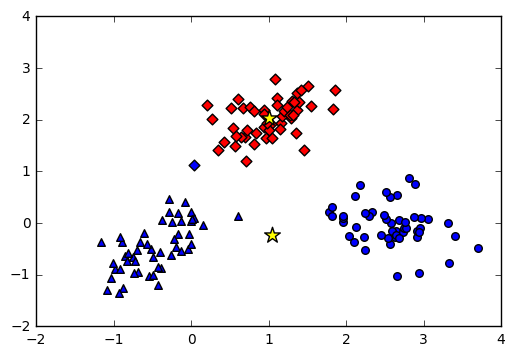

Evaualtion for Dataset:  dataset1.txt
Value of K  3
Log Likelihood:	 -594.652212346
NMI:	 1.0
SC:	 0.722205425437
CH:	 599.538582562
Means
[[ 2.57364536 -0.02745476]
 [-0.45958514 -0.45419686]
 [ 0.99614785  2.01730441]]
Variances
[[ 0.18023304  0.15159924]
 [ 0.14949778  0.22936809]
 [ 0.15538176  0.13518689]]


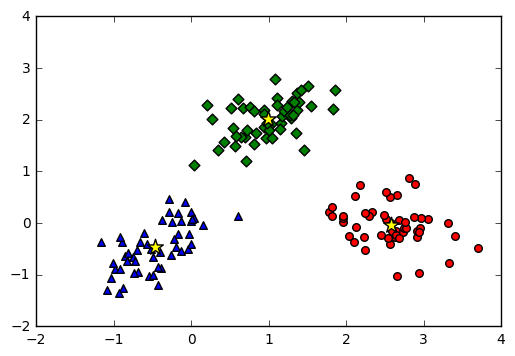

Evaualtion for Dataset:  dataset1.txt
Value of K  4


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in subtract


Log Likelihood:	 -576.932630393
NMI:	 0.886111348472
SC:	 0.631581016125
CH:	 529.901277934
Means
[[-0.72702548 -0.75349488]
 [ 1.00370529  2.02441943]
 [-0.08683496 -0.01864595]
 [ 2.57353371 -0.02744294]]
Variances
[[ 0.05442604  0.09740975]
 [ 0.14931036  0.12979548]
 [ 0.04424639  0.13777968]
 [ 0.18044013  0.15159411]]


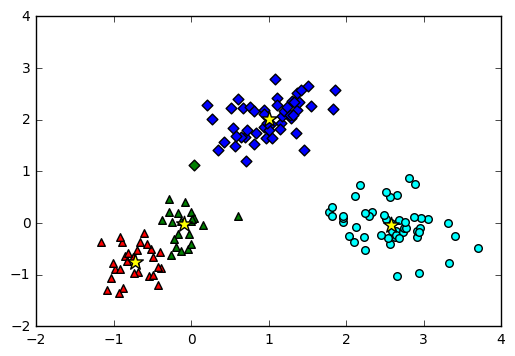

Evaualtion for Dataset:  dataset1.txt
Value of K  5
Log Likelihood:	 -570.164433146
NMI:	 0.843443114518
SC:	 0.533216766753
CH:	 488.772348515
Means
[[ 0.80009949  1.84212919]
 [ 1.33469818  2.31917672]
 [-0.08759493 -0.04547085]
 [-0.72226343 -0.75216166]
 [ 2.57353346 -0.02743001]]
Variances
[[ 0.11317741  0.10681001]
 [ 0.05911087  0.05017374]
 [ 0.04490161  0.09577118]
 [ 0.05605007  0.09676394]
 [ 0.18042946  0.15161007]]


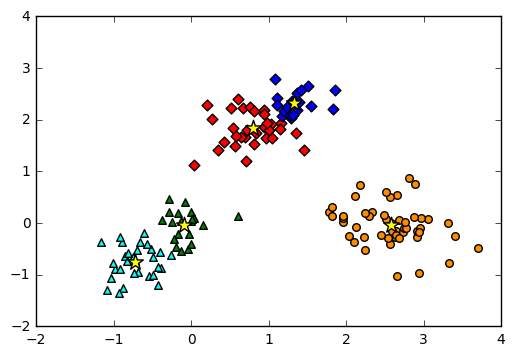

NMI for Dataset  dataset1.txt


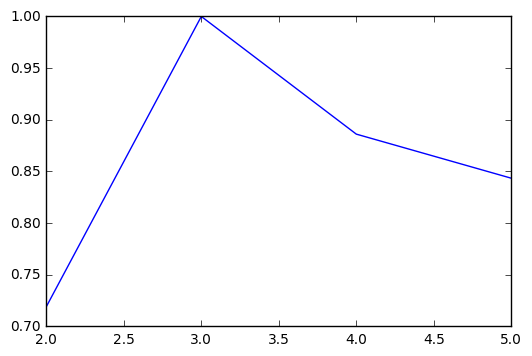

CH for Dataset  dataset1.txt


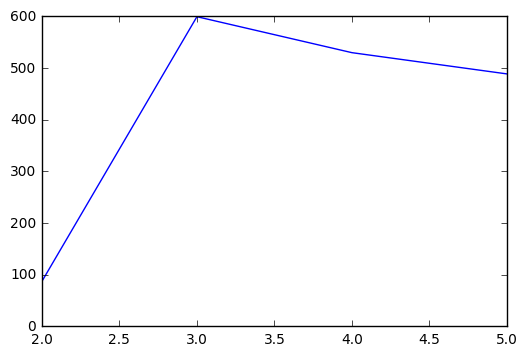

SC for Dataset  dataset1.txt


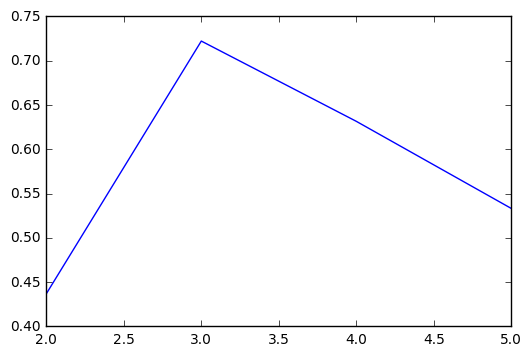

Log Likelihood for Dataset  dataset1.txt


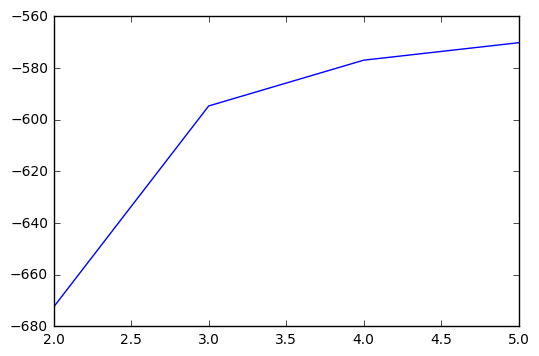

In [15]:
GMM('dataset1.txt',[2,3,4,5],None,None)

# GMM for Dataset 2
#### Note: Yellow Stars are Cluster centers

Evaualtion for Dataset:  dataset2.txt
Value of K  2


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


Log Likelihood:	 -1028.55037559
NMI:	 0.816496580928
SC:	 0.602699321851
CH:	 427.944135609
Means
[[  4.00720198e-01   4.31302417e-03]
 [  4.98006404e+00  -2.19513660e-02]]
Variances
[[ 1.33513791  1.78738766]
 [ 0.10426443  1.63634965]]


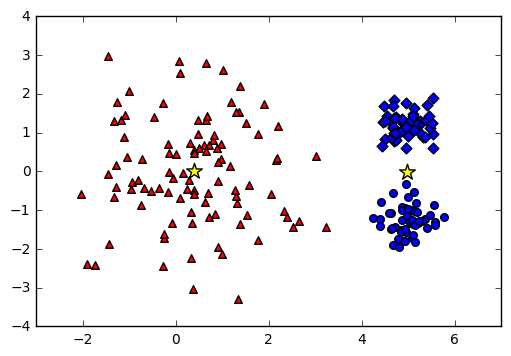

Evaualtion for Dataset:  dataset2.txt
Value of K  3
Log Likelihood:	 -962.907189681
NMI:	 1.0
SC:	 0.62096368991
CH:	 355.491409806
Means
[[  4.98952764e+00  -1.25707910e+00]
 [  3.99957758e-01   4.40795185e-03]
 [  4.97039514e+00   1.21285590e+00]]
Variances
[[ 0.10268428  0.12740556]
 [ 1.33230201  1.78733983]
 [ 0.10575888  0.09514923]]


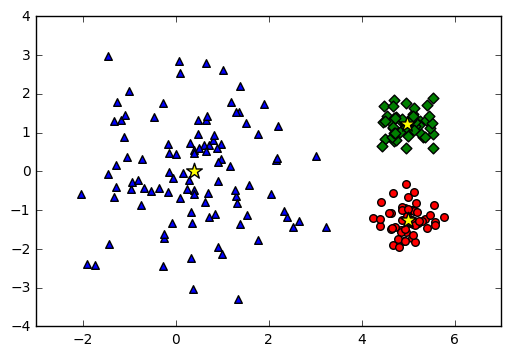

Evaualtion for Dataset:  dataset2.txt
Value of K  4


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in subtract


Log Likelihood:	 -957.013512176
NMI:	 0.955433836028
SC:	 0.503005662462
CH:	 270.691650383
Means
[[ 2.65043074 -1.28578472]
 [ 4.98940388 -1.25701663]
 [ 4.97032497  1.21282062]
 [ 0.29840472  0.06207647]]
Variances
[[ 0.10443819  0.02299742]
 [ 0.10273311  0.12742798]
 [ 0.10577638  0.09517137]
 [ 1.14658996  1.7886065 ]]


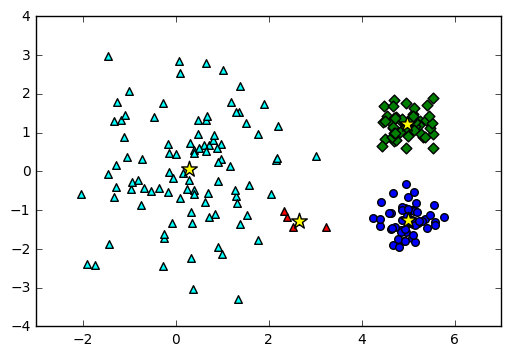

Evaualtion for Dataset:  dataset2.txt
Value of K  5
Log Likelihood:	 -954.669157229
NMI:	 0.827359059532
SC:	 0.515525401227
CH:	 351.133568143
Means
[[ 0.6977767   0.86323723]
 [ 4.98995603 -1.25725103]
 [-1.1852013   0.88145015]
 [ 4.97037678  1.21288764]
 [ 0.55093196 -0.83648375]]
Variances
[[ 0.43713234  1.01199183]
 [ 0.10250627  0.12733064]
 [ 0.03329411  1.201089  ]
 [ 0.10576005  0.09514863]
 [ 1.6429626   1.06533506]]


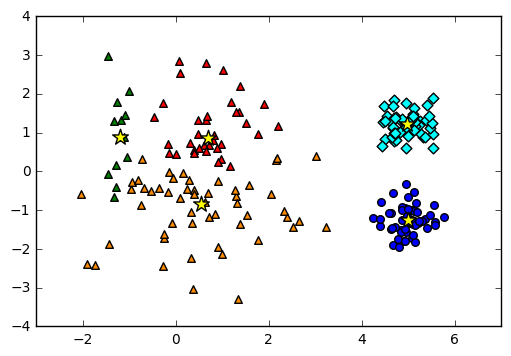

NMI for Dataset  dataset2.txt


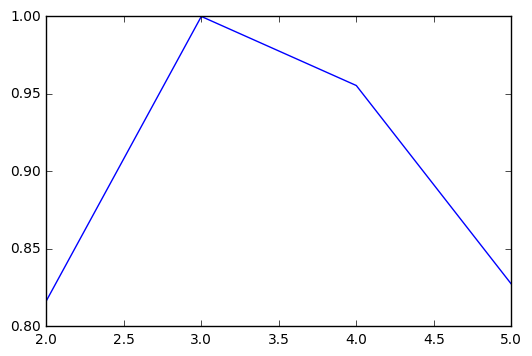

CH for Dataset  dataset2.txt


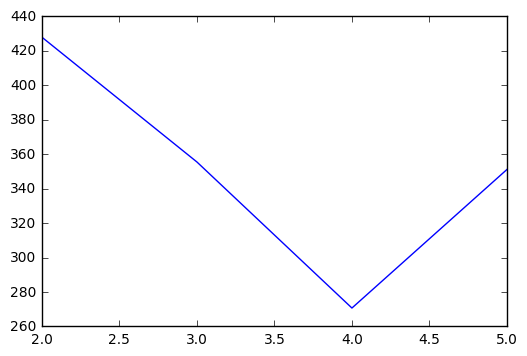

SC for Dataset  dataset2.txt


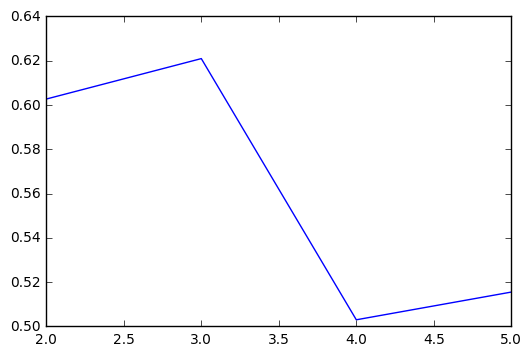

Log Likelihood for Dataset  dataset2.txt


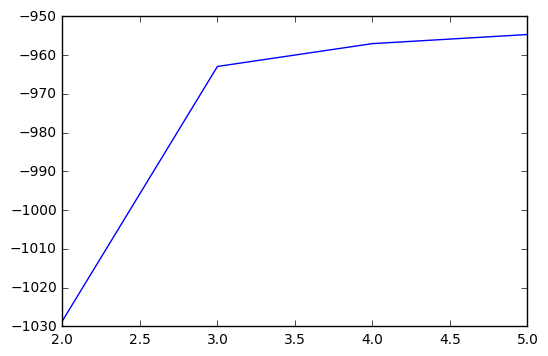

In [16]:
GMM('dataset2.txt',[2,3,4,5],None,None)

# GMM for Dataset 3
#### Note: Yellow Stars are Cluster centers

Evaualtion for Dataset:  dataset3.txt
Value of K  2


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


Log Likelihood:	 -705.935707817
NMI:	 0.488282223626
SC:	 0.474323003911
CH:	 274.774449513
Means
[[-0.16141167  0.67275918]
 [ 1.1482284  -0.13059846]]
Variances
[[ 0.35454756  0.07545775]
 [ 0.36343952  0.10043088]]


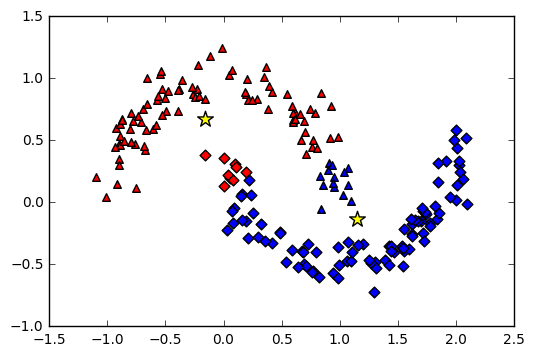

Evaualtion for Dataset:  dataset3.txt
Value of K  3
Log Likelihood:	 -679.164652117
NMI:	 0.506610686333
SC:	 0.380924878979
CH:	 172.15405479
Means
[[ 0.01756005  0.87258169]
 [ 1.05195976 -0.0663092 ]
 [-0.81551539  0.49930399]]
Variances
[[ 0.22614068  0.02064234]
 [ 0.40147413  0.12068487]
 [ 0.01503121  0.03612527]]


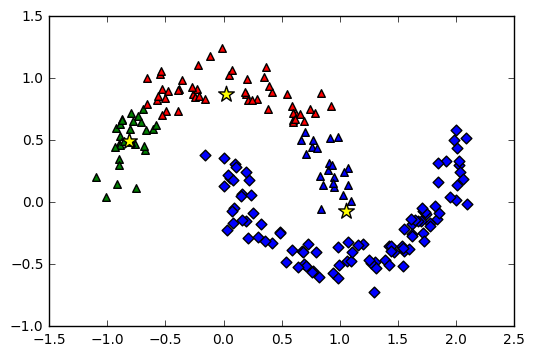

Evaualtion for Dataset:  dataset3.txt
Value of K  4
Log Likelihood:	 -657.55451449
NMI:	 0.457816786926
SC:	 0.433800427643
CH:	 299.320008641
Means
[[ 1.83530246  0.04015687]
 [-0.66739634  0.65043149]
 [ 1.11196751 -0.43735317]
 [ 0.44877539  0.40688241]]
Variances
[[ 0.02652294  0.06428546]
 [ 0.05132171  0.06253611]
 [ 0.1238356   0.01013649]
 [ 0.14727385  0.18448005]]


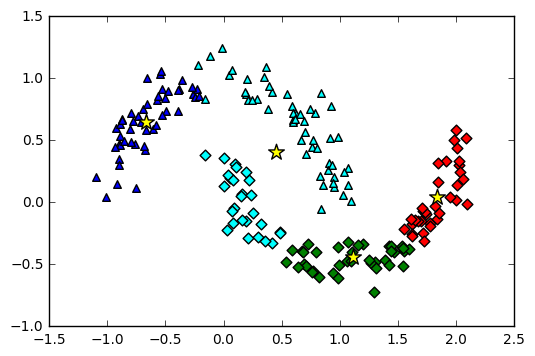

Evaualtion for Dataset:  dataset3.txt
Value of K  5


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in subtract


Log Likelihood:	 -634.37995534
NMI:	 0.458560290483
SC:	 0.410389822721
CH:	 305.171510338
Means
[[ 1.12516903 -0.43772299]
 [ 0.53064266  0.25770941]
 [ 1.83705856  0.04255309]
 [-0.81034613  0.50310096]
 [-0.16102023  0.91707568]]
Variances
[[ 0.12088837  0.01012494]
 [ 0.1332027   0.13713729]
 [ 0.02625362  0.06393473]
 [ 0.01612652  0.03720615]
 [ 0.13564319  0.01542408]]


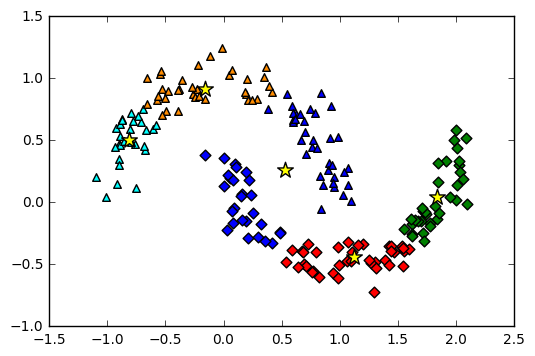

NMI for Dataset  dataset3.txt


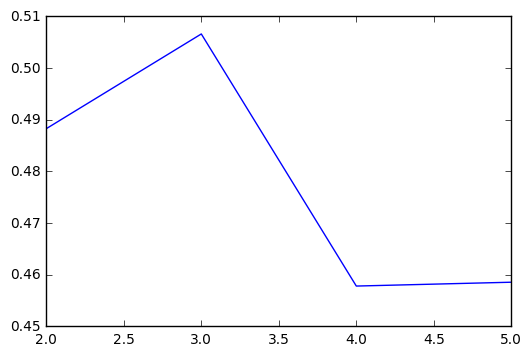

CH for Dataset  dataset3.txt


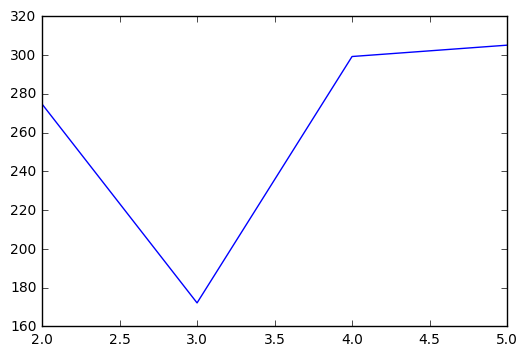

SC for Dataset  dataset3.txt


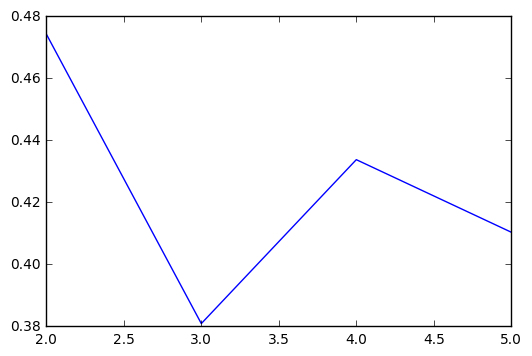

Log Likelihood for Dataset  dataset3.txt


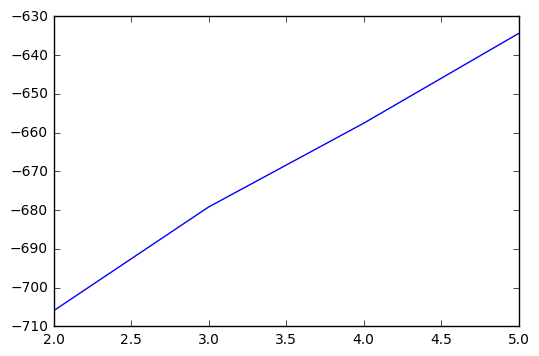

In [17]:
GMM('dataset3.txt',[2,3,4,5],None,None)

# Question 7

### - Which model performs best on dataset1? Can you explain why?

For dataset 1 GMM, KMenas and DBScan have NMI 1.0 which i the best result. Looking at SC we infer that SC should be closer to 1 to maximize intra-cluster similarity so DB Scan so we assume should be better better. Also DBScan removes noise points so assuming given labels to be true labels GMM and KMeans are better because they completelty identify true labels.

               GMM: NMI = 1.0 | SC: 0.722205425437 | CH: 599.538582562
               
               KMeans: NMI: 1.0 | SC: 0.722205425437 | CH: 599.538582562 
            
               DBScan:  NMI: 1.0 | SC: 0.737772089744 | CH:	655.625678


Since GMM is good for overlapping clusters and and  distance between different clusters in dataset 1 is high enough, KMeans is well suited for this configuration of points so I choose KMeans to be the best

               
### - Which model performs better on dataset2 and dataset3, GMM or Kmeans? Can explain the reason for this?

For Dataset 2 since it has cluster with high varying sensities GMM works better than KMeans and we get an NMI of 1.0 with k = 3 in GMM while not in KMeans since KMeans doesn't take variance of clusters into consideration, it only takes SSEs

Considering the shape of Data, DBScan outperforms both KMeans and GMM, because of the banana shape (non globular shaped data) GMM performs better with NMI around 0.5 than KMeans with NMI around 0.2. 

The best clustering is DBScan since it works best on non globular shapes

